In [1]:
#!pip install tensorflow==2.7.0

In [2]:
#pip install opencv-python-headless

In [3]:
from distutils import extension
from logging import exception
import os
from datetime import datetime as dt
from regex import E
from sqlalchemy import intersect
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np 
import pathlib
from keras.callbacks import ModelCheckpoint   
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/cbisddsm"

Test_output_full  Test_output_mask  Train_output_full  Train_output_mask


In [6]:
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Images/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Images/Test')

In [7]:
seed = 43
encoder_input_width = 224
encode_input_channels = 3
encoder_input_shape = (encoder_input_width, encoder_input_width, encode_input_channels)

kernsize = 3
decoder_kernel_size = (kernsize, kernsize)
stride = 2
decoder_strides = (stride, stride)
decoder_padding = "same"
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"

train_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_full"
train_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_mask"

test_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_full"
test_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_mask"
results_dir = "/content/results/fit"
extension = ".png"

target_size = (224, 224)

brightness_delta = 0.3
batch_size = 10

weight_decay = 1e-4

validate = False
loss = "binary_crossentropy"
learning_rate = 0.0001
dropout = 0.5
dropout_training = True
num_epochs = 100
callback_monitor = "iouMetric"
callback_mode = "max"
ckpt_save_weights_only = True
ckpt_save_best_only = True
earlystop_patience = 200
restore_best_weights = True

In [8]:
# x_paths_list = []
# for full in os.listdir(train_full_img_dir):
#   if full.endswith(extension):
#     x_paths_list.append(os.path.join(train_full_img_dir, full))

# print(len(x_paths_list))

In [9]:
def datasetPaths(full_img_dir, mask_img_dir):
        try:
            x_paths_list = []
            y_paths_list = []

            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))
            
            for full in os.listdir(mask_img_dir):
                if full.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, full))
            
            x_paths_list.sort()
            y_paths_list.sort()

            return x_paths_list, y_paths_list
        except Exception as e:
            print(f"Error in datasetPaths {e}")

In [10]:
# def loadFullImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path = path.decode()
             
            
#             s3_client = boto3.resource('s3')
#             obj = s3_client.get_object(Bucket='cbisddsm', Key=path)
#             nparr = np.frombuffer(obj['Body'].read(), np.uint8)
#             img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#             print(f'type type{img}')
#             #bucket = s3_resource.Bucket('cbisddsm')
#             #print(f'bucket.Object(path) {bucket.Object(path)}')
#             #img = bucket.Object(path).get().get('Body').read()
#             #print(f'img {img}')
#             #img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
           
            
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
#             print(f'done for path {path}')
#             return full_img
        
#         except Exception as e:
#             print(f"There is an error in loadFullImg {e}")
            

    
 

In [11]:
def loadFullImg(path, dsize):
        try:
            if not isinstance(path, str):
                path = path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            #print(type(img))
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())
            #print(f'After norm_img')
            #print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            #print(f'After full_img')
            #print(f'type {full_img.shape}')
            #print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [12]:
# s3 = boto3.resource('s3')
# my_bucket = s3.Bucket('cbisddsm')
# i = 0
# for object_summary in my_bucket.objects.filter(Prefix='Train_output_full'):    
#     if i == 0:
#         pass
#     else:
#         print(object_summary.key)
#         img = loadFullImg(object_summary.key, target_size)
#         print(img.shape)
#         #break
#     i += 1
    
    
#             #print(object_summary.key)
        
#             #x_paths_list.append(object_summary.key)


In [13]:
def loadMaskImg(path, dsize):
        try:
            if not isinstance(path, str):
                path=path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            #print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [14]:
# def loadMaskImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path=path.decode()
             
#             s3_resource = boto3.resource('s3')
#             bucket = s3_resource.Bucket('cbisddsm')
# #             bucket = s3_resource.Bucket('cbisddsm')
#             img = bucket.Object(path).get().get('Body').read()
#             img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
#             print(f'type type(img)')
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             mask_img = np.expand_dims(norm_img, axis=-1)

#             return mask_img

#         except Exception as e:
#             print("Error in loadMaskIMG")

In [15]:
def tfParse(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [16]:
def imgAugment(x_img, y_img):
        try:
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            x_img = tf.image.random_brightness(
                image=x_img, max_delta=brightness_delta
            )

            return x_img, y_img

        except:
            print("Erro in imgAugument")

In [17]:
 def makeTFDataset( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [18]:
def buildEncoder():
        try:
            VGG16_ = keras.applications.VGG16(
                include_top=False, weights="imagenet", input_shape=encoder_input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
               VGG16_.get_layer(layer).output for layer in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

            return encoder_model 
        
        except Exception as e:
            print("Error in buildEncoder")

In [19]:
def buildUnet():
        try:
            unet_input = keras.Input(
                shape= encoder_input_shape, name="unet_input_layer"
            )

            x = unet_input
            encoder_model = buildEncoder()
            all_encoder_layer_outputs = encoder_model(x)

            encoded_img = all_encoder_layer_outputs[-1]

            #skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5,9, 13, 17]]
            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 4, 6, 12, 15]]
            
            decoder_filters = int(encoded_img.shape[-1])

            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            #  - `encoded_img` as initial input for decoder
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=decoder_kernel_size,
                kernel_regularizer=l2(weight_decay), 
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                kernel_regularizer=l2(weight_decay), 
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=decoder_strides,
                padding=decoder_padding,
                kernel_regularizer=l2(weight_decay), 
                activation=decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=dropout, seed=seed
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=final_layer_filters,
                kernel_size=decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                kernel_regularizer=l2(weight_decay), 
                activation=final_layer_activation,
            )(decoded_img)

            # ======
            #  Unet
            # ======

            unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

            return unet
        except Exception as e:
            print(f"Error in Build Unet {e}")

In [20]:
def iouMetric( y_true, y_pred):
        try:
            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x
            
            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)
            
        except Exception as e:
            print(f"Error in iouMetric {E}")

In [21]:
def dice_coef(y_true, y_pred):
        try:
            # def dice(true, pred, k = 1):
            #     intersection = np.sum(pred[true==k]) * 2.0
            #     dice = intersection / (np.sum(pred) + np.sum(true))
            #     return dice 
            # return tf.numpy_function(dice, [y_true, y_pred], tf.double)
            
            y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
            y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
        except Exception as e:
            print(f"Error in dice_coef {e}")

In [22]:
def compile_( model):
        try:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            metrics = ["accuracy", iouMetric, dice_coef]
            model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

            return model
        except Exception as e:
            print(f"Failed at compile_ {e}")

In [23]:
 test_x, test_y = datasetPaths(
            full_img_dir=test_full_img_dir,
            mask_img_dir=test_mask_img_dir
        )
        

In [24]:
# def evaluate(path,target_size):
#   full_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     full_img = loadFullImg(imgpath, target_size)
#     full_img_lst.append(full_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return full_img_lst
  
# full_img_lst = evaluate(test_x, target_size)

In [25]:
# def evaluate_mask(path,target_size):
#   mask_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     mask_img = loadMaskImg(imgpath, target_size)
#     mask_img_lst.append(mask_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return mask_img_lst
  
# mask_img_lst = evaluate(test_y, target_size)

In [26]:
# img = cv2.imread(test_x[0], cv2.IMREAD_GRAYSCALE)
# print(img)

In [27]:
# actual_x, actual_y =tfParse(test_x, test_y)

In [28]:
# full_img_lst[0]

In [29]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)  
model_time = dt.now().strftime("%Y%m%d_%H%M%S")
model_folder = os.path.join(results_dir, model_time)
os.makedirs(model_folder)

tensorboard_folder = os.path.join(model_folder, "tensorlogs")
os.makedirs(tensorboard_folder)

ckpt_folder = os.path.join(model_folder, "checkpoints")
os.makedirs(ckpt_folder)

csv_logger_folder = os.path.join(model_folder, "csv_logger")
os.makedirs(csv_logger_folder)

hist_folder = os.path.join(model_folder, "model_history")
os.makedirs(hist_folder)

saved_model_folder = os.path.join(model_folder, "Saved_model")
os.makedirs(saved_model_folder)

model_params_folder = os.path.join(model_folder, "model_params")
os.makedirs(model_params_folder)

train_x, train_y = datasetPaths(
    full_img_dir=train_full_img_dir,
    mask_img_dir=train_mask_img_dir 
)

test_x, test_y = datasetPaths(
    full_img_dir=test_full_img_dir,
    mask_img_dir=test_mask_img_dir
)

train_ds = makeTFDataset(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)


test_ds = makeTFDataset(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)      
    
unet = buildUnet()

unet = compile_(model=unet)

# ckpt_path = (ckpt_folder + f"/{model_time}" + "_Epoch-{epoch:03d}" + "_IOU-{iouMetric:.8f")
ckpt_path = (ckpt_folder + f"/{model_time}")

ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath= ckpt_path,
    monitors= callback_monitor,
    mode= callback_mode,
    save_weights_only= ckpt_save_weights_only,
    save_best_only=ckpt_save_best_only,
    verbose=1
)

es_callback = keras.callbacks.EarlyStopping(
    patience= earlystop_patience,
    monitor= callback_monitor,
    mode= callback_mode,
    restore_best_weights= restore_best_weights,
)

# TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_folder, histogram_freq=1, profile_batch=0
)

# CSV Logger
csv_logger_path = os.path.join(csv_logger_folder, "csv_logger.csv")
csv_logger = keras.callbacks.CSVLogger(
    filename=csv_logger_path, separator=",", append=True
)

# Putting them together
callbacks = [ckpt_callback, es_callback, tb_callback, csv_logger, checkpointer]

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1

print()
print(f"Size of training set = {len(train_x)}")
print(f"Size of test set = {len(test_x)}")
print(f"Number of epochs = {num_epochs}")
print(f"Batch size = {batch_size}")
print(f"Number of training steps per epoch = {train_steps}")
print(f"Number of test steps per epoch = {test_steps}")
print()

if validate:
        history = unet.fit(
            train_ds,
            validation_data=test_ds,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_steps=test_steps,
            callbacks=callbacks,
            verbose=1,
        )
elif not validate:
    history = unet.fit(
        train_ds,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        callbacks=callbacks,
        verbose=1
    )

#y_hat = unet.evaluate(test_ds)

print("Completed")     
        

58900480/58889256 [==============================] - 0s 0us/step

Size of training set = 1231
Size of test set = 361
Number of epochs = 100
Batch size = 10
Number of training steps per epoch = 124
Number of test steps per epoch = 37

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.9809 - iouMetric: 0.0026 - dice_coef: 0.0054

124/124 [==============================] - 413s 3s/step - loss: 0.4923 - accuracy: 0.9809 - iouMetric: 0.0026 - dice_coef: 0.0054
Epoch 2/100
123/124 [============================>.] - ETA: 1s - loss: 0.2124 - accuracy: 0.9959 - iouMetric: 0.0375 - dice_coef: 0.0717

124/124 [==============================] - 201s 2s/step - loss: 0.2124 - accuracy: 0.9959 - iouMetric: 0.0383 - dice_coef: 0.0729
Epoch 3/100
123/124 [============================>.] - ETA: 1s - loss: 0.1344 - accuracy: 0.9960 - iouMetric: 0.0880 - dice_coef: 0.1600

124/124 [==============================] - 203s 2s/step - loss: 0.1344 - accuracy: 0.9960 - iouMetric: 0.0873 - dice_coef: 0.1587
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9961 - iouMetric: 0.1133 - dice_coef: 0.2013

124/124 [==============================] - 199s 2s/step - loss: 0.1052 - accuracy: 0.9961 - iouMetric: 0.1133 - dice_coef: 0.2013
Epoch 5/100
123/124 [============================>.] - ETA: 1s - loss: 0.0900 - accuracy: 0.9962 - iouMetric: 0.1214 - dice_coef: 0.2138

124/124 [==============================] - 198s 2s/step - loss: 0.0900 - accuracy: 0.9962 - iouMetric: 0.1213 - dice_coef: 0.2136
Epoch 6/100
123/124 [============================>.] - ETA: 1s - loss: 0.0796 - accuracy: 0.9962 - iouMetric: 0.1275 - dice_coef: 0.2236

124/124 [==============================] - 199s 2s/step - loss: 0.0796 - accuracy: 0.9962 - iouMetric: 0.1266 - dice_coef: 0.2219
Epoch 7/100
123/124 [============================>.] - ETA: 1s - loss: 0.0720 - accuracy: 0.9964 - iouMetric: 0.1362 - dice_coef: 0.2364

124/124 [==============================] - 199s 2s/step - loss: 0.0720 - accuracy: 0.9964 - iouMetric: 0.1352 - dice_coef: 0.2347
Epoch 8/100
124/124 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9964 - iouMetric: 0.1481 - dice_coef: 0.2551

124/124 [==============================] - 205s 2s/step - loss: 0.0659 - accuracy: 0.9964 - iouMetric: 0.1481 - dice_coef: 0.2551
Epoch 9/100
124/124 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9965 - iouMetric: 0.1435 - dice_coef: 0.2469

124/124 [==============================] - 200s 2s/step - loss: 0.0612 - accuracy: 0.9965 - iouMetric: 0.1435 - dice_coef: 0.2469
Epoch 10/100
123/124 [============================>.] - ETA: 1s - loss: 0.0571 - accuracy: 0.9965 - iouMetric: 0.1506 - dice_coef: 0.2579

124/124 [==============================] - 200s 2s/step - loss: 0.0571 - accuracy: 0.9965 - iouMetric: 0.1504 - dice_coef: 0.2577
Epoch 11/100
123/124 [============================>.] - ETA: 1s - loss: 0.0540 - accuracy: 0.9964 - iouMetric: 0.1472 - dice_coef: 0.2520

124/124 [==============================] - 201s 2s/step - loss: 0.0540 - accuracy: 0.9964 - iouMetric: 0.1475 - dice_coef: 0.2525
Epoch 12/100
123/124 [============================>.] - ETA: 1s - loss: 0.0510 - accuracy: 0.9965 - iouMetric: 0.1495 - dice_coef: 0.2561

124/124 [==============================] - 202s 2s/step - loss: 0.0510 - accuracy: 0.9965 - iouMetric: 0.1512 - dice_coef: 0.2584
Epoch 13/100
123/124 [============================>.] - ETA: 1s - loss: 0.0482 - accuracy: 0.9965 - iouMetric: 0.1547 - dice_coef: 0.2645

124/124 [==============================] - 202s 2s/step - loss: 0.0482 - accuracy: 0.9965 - iouMetric: 0.1536 - dice_coef: 0.2627
Epoch 14/100
123/124 [============================>.] - ETA: 1s - loss: 0.0461 - accuracy: 0.9965 - iouMetric: 0.1568 - dice_coef: 0.2664

124/124 [==============================] - 203s 2s/step - loss: 0.0461 - accuracy: 0.9965 - iouMetric: 0.1565 - dice_coef: 0.2661
Epoch 15/100
123/124 [============================>.] - ETA: 1s - loss: 0.0440 - accuracy: 0.9966 - iouMetric: 0.1609 - dice_coef: 0.2739

124/124 [==============================] - 204s 2s/step - loss: 0.0440 - accuracy: 0.9966 - iouMetric: 0.1601 - dice_coef: 0.2727
Epoch 16/100
123/124 [============================>.] - ETA: 1s - loss: 0.0421 - accuracy: 0.9967 - iouMetric: 0.1646 - dice_coef: 0.2786

124/124 [==============================] - 202s 2s/step - loss: 0.0421 - accuracy: 0.9967 - iouMetric: 0.1641 - dice_coef: 0.2779
Epoch 17/100
124/124 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 0.9966 - iouMetric: 0.1626 - dice_coef: 0.2743

124/124 [==============================] - 203s 2s/step - loss: 0.0406 - accuracy: 0.9966 - iouMetric: 0.1626 - dice_coef: 0.2743
Epoch 18/100
124/124 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9966 - iouMetric: 0.1675 - dice_coef: 0.2828

124/124 [==============================] - 203s 2s/step - loss: 0.0390 - accuracy: 0.9966 - iouMetric: 0.1675 - dice_coef: 0.2828
Epoch 19/100
124/124 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9966 - iouMetric: 0.1690 - dice_coef: 0.2841

124/124 [==============================] - 206s 2s/step - loss: 0.0375 - accuracy: 0.9966 - iouMetric: 0.1690 - dice_coef: 0.2841
Epoch 20/100
123/124 [============================>.] - ETA: 1s - loss: 0.0364 - accuracy: 0.9966 - iouMetric: 0.1655 - dice_coef: 0.2797

124/124 [==============================] - 206s 2s/step - loss: 0.0364 - accuracy: 0.9966 - iouMetric: 0.1644 - dice_coef: 0.2780
Epoch 21/100
124/124 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9966 - iouMetric: 0.1693 - dice_coef: 0.2856

124/124 [==============================] - 206s 2s/step - loss: 0.0350 - accuracy: 0.9966 - iouMetric: 0.1693 - dice_coef: 0.2856
Epoch 22/100
123/124 [============================>.] - ETA: 1s - loss: 0.0340 - accuracy: 0.9967 - iouMetric: 0.1808 - dice_coef: 0.3006

124/124 [==============================] - 207s 2s/step - loss: 0.0340 - accuracy: 0.9967 - iouMetric: 0.1793 - dice_coef: 0.2983
Epoch 23/100
124/124 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9966 - iouMetric: 0.1699 - dice_coef: 0.2858

124/124 [==============================] - 204s 2s/step - loss: 0.0331 - accuracy: 0.9966 - iouMetric: 0.1699 - dice_coef: 0.2858
Epoch 24/100
124/124 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9967 - iouMetric: 0.1766 - dice_coef: 0.2952

124/124 [==============================] - 204s 2s/step - loss: 0.0320 - accuracy: 0.9967 - iouMetric: 0.1766 - dice_coef: 0.2952
Epoch 25/100
123/124 [============================>.] - ETA: 1s - loss: 0.0312 - accuracy: 0.9967 - iouMetric: 0.1745 - dice_coef: 0.2912

124/124 [==============================] - 205s 2s/step - loss: 0.0312 - accuracy: 0.9966 - iouMetric: 0.1731 - dice_coef: 0.2889
Epoch 26/100
123/124 [============================>.] - ETA: 1s - loss: 0.0302 - accuracy: 0.9967 - iouMetric: 0.1791 - dice_coef: 0.2989

124/124 [==============================] - 205s 2s/step - loss: 0.0302 - accuracy: 0.9967 - iouMetric: 0.1777 - dice_coef: 0.2965
Epoch 27/100
123/124 [============================>.] - ETA: 1s - loss: 0.0294 - accuracy: 0.9967 - iouMetric: 0.1808 - dice_coef: 0.3009

124/124 [==============================] - 205s 2s/step - loss: 0.0294 - accuracy: 0.9967 - iouMetric: 0.1800 - dice_coef: 0.2997
Epoch 28/100
123/124 [============================>.] - ETA: 1s - loss: 0.0284 - accuracy: 0.9967 - iouMetric: 0.1896 - dice_coef: 0.3139

124/124 [==============================] - 207s 2s/step - loss: 0.0284 - accuracy: 0.9967 - iouMetric: 0.1889 - dice_coef: 0.3129
Epoch 29/100
124/124 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9968 - iouMetric: 0.1915 - dice_coef: 0.3170

124/124 [==============================] - 206s 2s/step - loss: 0.0277 - accuracy: 0.9968 - iouMetric: 0.1915 - dice_coef: 0.3170
Epoch 30/100
123/124 [============================>.] - ETA: 1s - loss: 0.0270 - accuracy: 0.9967 - iouMetric: 0.1864 - dice_coef: 0.3095

124/124 [==============================] - 205s 2s/step - loss: 0.0270 - accuracy: 0.9967 - iouMetric: 0.1851 - dice_coef: 0.3074
Epoch 31/100
124/124 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9966 - iouMetric: 0.1635 - dice_coef: 0.2748

124/124 [==============================] - 205s 2s/step - loss: 0.0272 - accuracy: 0.9966 - iouMetric: 0.1635 - dice_coef: 0.2748
Epoch 32/100
123/124 [============================>.] - ETA: 1s - loss: 0.0257 - accuracy: 0.9968 - iouMetric: 0.1884 - dice_coef: 0.3126

124/124 [==============================] - 205s 2s/step - loss: 0.0257 - accuracy: 0.9968 - iouMetric: 0.1887 - dice_coef: 0.3131
Epoch 33/100
123/124 [============================>.] - ETA: 1s - loss: 0.0250 - accuracy: 0.9968 - iouMetric: 0.1975 - dice_coef: 0.3247

124/124 [==============================] - 204s 2s/step - loss: 0.0250 - accuracy: 0.9968 - iouMetric: 0.1983 - dice_coef: 0.3258
Epoch 34/100
123/124 [============================>.] - ETA: 1s - loss: 0.0245 - accuracy: 0.9968 - iouMetric: 0.1981 - dice_coef: 0.3251

124/124 [==============================] - 206s 2s/step - loss: 0.0245 - accuracy: 0.9968 - iouMetric: 0.1974 - dice_coef: 0.3242
Epoch 35/100
123/124 [============================>.] - ETA: 1s - loss: 0.0239 - accuracy: 0.9968 - iouMetric: 0.1989 - dice_coef: 0.3269

124/124 [==============================] - 205s 2s/step - loss: 0.0239 - accuracy: 0.9968 - iouMetric: 0.1974 - dice_coef: 0.3245
Epoch 36/100
124/124 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9969 - iouMetric: 0.2038 - dice_coef: 0.3336

124/124 [==============================] - 206s 2s/step - loss: 0.0232 - accuracy: 0.9969 - iouMetric: 0.2038 - dice_coef: 0.3336
Epoch 37/100
123/124 [============================>.] - ETA: 1s - loss: 0.0227 - accuracy: 0.9968 - iouMetric: 0.2051 - dice_coef: 0.3356

124/124 [==============================] - 203s 2s/step - loss: 0.0227 - accuracy: 0.9968 - iouMetric: 0.2038 - dice_coef: 0.3335
Epoch 38/100
123/124 [============================>.] - ETA: 1s - loss: 0.0223 - accuracy: 0.9968 - iouMetric: 0.2061 - dice_coef: 0.3365

124/124 [==============================] - 203s 2s/step - loss: 0.0223 - accuracy: 0.9968 - iouMetric: 0.2049 - dice_coef: 0.3346
Epoch 39/100
123/124 [============================>.] - ETA: 1s - loss: 0.0216 - accuracy: 0.9969 - iouMetric: 0.2150 - dice_coef: 0.3485

124/124 [==============================] - 205s 2s/step - loss: 0.0216 - accuracy: 0.9969 - iouMetric: 0.2134 - dice_coef: 0.3461
Epoch 40/100
124/124 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9969 - iouMetric: 0.2041 - dice_coef: 0.3328

124/124 [==============================] - 207s 2s/step - loss: 0.0214 - accuracy: 0.9969 - iouMetric: 0.2041 - dice_coef: 0.3328
Epoch 41/100
123/124 [============================>.] - ETA: 1s - loss: 0.0207 - accuracy: 0.9969 - iouMetric: 0.2209 - dice_coef: 0.3553

124/124 [==============================] - 207s 2s/step - loss: 0.0207 - accuracy: 0.9969 - iouMetric: 0.2207 - dice_coef: 0.3551
Epoch 42/100
123/124 [============================>.] - ETA: 1s - loss: 0.0207 - accuracy: 0.9969 - iouMetric: 0.2019 - dice_coef: 0.3296

124/124 [==============================] - 206s 2s/step - loss: 0.0207 - accuracy: 0.9969 - iouMetric: 0.2016 - dice_coef: 0.3293
Epoch 43/100
124/124 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9969 - iouMetric: 0.2161 - dice_coef: 0.3492

124/124 [==============================] - 206s 2s/step - loss: 0.0200 - accuracy: 0.9969 - iouMetric: 0.2161 - dice_coef: 0.3492
Epoch 44/100
124/124 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9969 - iouMetric: 0.2226 - dice_coef: 0.3578

124/124 [==============================] - 207s 2s/step - loss: 0.0195 - accuracy: 0.9969 - iouMetric: 0.2226 - dice_coef: 0.3578
Epoch 45/100
123/124 [============================>.] - ETA: 1s - loss: 0.0189 - accuracy: 0.9970 - iouMetric: 0.2280 - dice_coef: 0.3646

124/124 [==============================] - 209s 2s/step - loss: 0.0189 - accuracy: 0.9970 - iouMetric: 0.2289 - dice_coef: 0.3657
Epoch 46/100
123/124 [============================>.] - ETA: 1s - loss: 0.0187 - accuracy: 0.9970 - iouMetric: 0.2272 - dice_coef: 0.3641

124/124 [==============================] - 205s 2s/step - loss: 0.0187 - accuracy: 0.9970 - iouMetric: 0.2253 - dice_coef: 0.3612
Epoch 47/100
123/124 [============================>.] - ETA: 1s - loss: 0.0181 - accuracy: 0.9971 - iouMetric: 0.2305 - dice_coef: 0.3672

124/124 [==============================] - 206s 2s/step - loss: 0.0181 - accuracy: 0.9971 - iouMetric: 0.2312 - dice_coef: 0.3681
Epoch 48/100
123/124 [============================>.] - ETA: 1s - loss: 0.0180 - accuracy: 0.9970 - iouMetric: 0.2323 - dice_coef: 0.3698

124/124 [==============================] - 209s 2s/step - loss: 0.0180 - accuracy: 0.9970 - iouMetric: 0.2309 - dice_coef: 0.3679
Epoch 49/100
124/124 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9970 - iouMetric: 0.2412 - dice_coef: 0.3827

124/124 [==============================] - 210s 2s/step - loss: 0.0175 - accuracy: 0.9970 - iouMetric: 0.2412 - dice_coef: 0.3827
Epoch 50/100
123/124 [============================>.] - ETA: 1s - loss: 0.0175 - accuracy: 0.9970 - iouMetric: 0.2301 - dice_coef: 0.3687

124/124 [==============================] - 206s 2s/step - loss: 0.0175 - accuracy: 0.9970 - iouMetric: 0.2315 - dice_coef: 0.3704
Epoch 51/100
123/124 [============================>.] - ETA: 1s - loss: 0.0171 - accuracy: 0.9970 - iouMetric: 0.2340 - dice_coef: 0.3740

124/124 [==============================] - 206s 2s/step - loss: 0.0171 - accuracy: 0.9970 - iouMetric: 0.2329 - dice_coef: 0.3726
Epoch 52/100
123/124 [============================>.] - ETA: 1s - loss: 0.0163 - accuracy: 0.9971 - iouMetric: 0.2526 - dice_coef: 0.3978

124/124 [==============================] - 206s 2s/step - loss: 0.0163 - accuracy: 0.9971 - iouMetric: 0.2531 - dice_coef: 0.3985
Epoch 53/100
123/124 [============================>.] - ETA: 1s - loss: 0.0164 - accuracy: 0.9971 - iouMetric: 0.2422 - dice_coef: 0.3826

124/124 [==============================] - 205s 2s/step - loss: 0.0164 - accuracy: 0.9971 - iouMetric: 0.2433 - dice_coef: 0.3840
Epoch 54/100
123/124 [============================>.] - ETA: 1s - loss: 0.0159 - accuracy: 0.9971 - iouMetric: 0.2506 - dice_coef: 0.3946

124/124 [==============================] - 206s 2s/step - loss: 0.0160 - accuracy: 0.9971 - iouMetric: 0.2512 - dice_coef: 0.3954
Epoch 55/100
124/124 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9968 - iouMetric: 0.2059 - dice_coef: 0.3341

124/124 [==============================] - 207s 2s/step - loss: 0.0170 - accuracy: 0.9968 - iouMetric: 0.2059 - dice_coef: 0.3341
Epoch 56/100
123/124 [============================>.] - ETA: 1s - loss: 0.0154 - accuracy: 0.9972 - iouMetric: 0.2580 - dice_coef: 0.4036

124/124 [==============================] - 208s 2s/step - loss: 0.0153 - accuracy: 0.9972 - iouMetric: 0.2576 - dice_coef: 0.4031
Epoch 57/100
123/124 [============================>.] - ETA: 1s - loss: 0.0152 - accuracy: 0.9972 - iouMetric: 0.2578 - dice_coef: 0.4031

124/124 [==============================] - 208s 2s/step - loss: 0.0152 - accuracy: 0.9972 - iouMetric: 0.2573 - dice_coef: 0.4026
Epoch 58/100
123/124 [============================>.] - ETA: 1s - loss: 0.0151 - accuracy: 0.9971 - iouMetric: 0.2567 - dice_coef: 0.4022

124/124 [==============================] - 207s 2s/step - loss: 0.0151 - accuracy: 0.9971 - iouMetric: 0.2551 - dice_coef: 0.3998
Epoch 59/100
123/124 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9972 - iouMetric: 0.2542 - dice_coef: 0.3981

124/124 [==============================] - 208s 2s/step - loss: 0.0149 - accuracy: 0.9972 - iouMetric: 0.2527 - dice_coef: 0.3959
Epoch 60/100
124/124 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9972 - iouMetric: 0.2610 - dice_coef: 0.4076

124/124 [==============================] - 208s 2s/step - loss: 0.0145 - accuracy: 0.9972 - iouMetric: 0.2610 - dice_coef: 0.4076
Epoch 61/100
123/124 [============================>.] - ETA: 1s - loss: 0.0144 - accuracy: 0.9972 - iouMetric: 0.2589 - dice_coef: 0.4047

124/124 [==============================] - 206s 2s/step - loss: 0.0144 - accuracy: 0.9972 - iouMetric: 0.2587 - dice_coef: 0.4045
Epoch 62/100
123/124 [============================>.] - ETA: 1s - loss: 0.0143 - accuracy: 0.9972 - iouMetric: 0.2588 - dice_coef: 0.4035

124/124 [==============================] - 207s 2s/step - loss: 0.0143 - accuracy: 0.9972 - iouMetric: 0.2575 - dice_coef: 0.4017
Epoch 63/100
123/124 [============================>.] - ETA: 1s - loss: 0.0140 - accuracy: 0.9972 - iouMetric: 0.2708 - dice_coef: 0.4200

124/124 [==============================] - 206s 2s/step - loss: 0.0140 - accuracy: 0.9972 - iouMetric: 0.2698 - dice_coef: 0.4187
Epoch 64/100
123/124 [============================>.] - ETA: 1s - loss: 0.0136 - accuracy: 0.9973 - iouMetric: 0.2811 - dice_coef: 0.4322

124/124 [==============================] - 206s 2s/step - loss: 0.0136 - accuracy: 0.9973 - iouMetric: 0.2809 - dice_coef: 0.4320
Epoch 65/100
123/124 [============================>.] - ETA: 1s - loss: 0.0134 - accuracy: 0.9973 - iouMetric: 0.2782 - dice_coef: 0.4283

124/124 [==============================] - 206s 2s/step - loss: 0.0134 - accuracy: 0.9973 - iouMetric: 0.2796 - dice_coef: 0.4299
Epoch 66/100
123/124 [============================>.] - ETA: 1s - loss: 0.0133 - accuracy: 0.9973 - iouMetric: 0.2812 - dice_coef: 0.4320

124/124 [==============================] - 208s 2s/step - loss: 0.0133 - accuracy: 0.9973 - iouMetric: 0.2821 - dice_coef: 0.4331
Epoch 67/100
123/124 [============================>.] - ETA: 1s - loss: 0.0139 - accuracy: 0.9972 - iouMetric: 0.2593 - dice_coef: 0.4040

124/124 [==============================] - 209s 2s/step - loss: 0.0139 - accuracy: 0.9972 - iouMetric: 0.2619 - dice_coef: 0.4066
Epoch 68/100
123/124 [============================>.] - ETA: 1s - loss: 0.0131 - accuracy: 0.9973 - iouMetric: 0.2813 - dice_coef: 0.4324

124/124 [==============================] - 209s 2s/step - loss: 0.0131 - accuracy: 0.9973 - iouMetric: 0.2804 - dice_coef: 0.4313
Epoch 69/100
123/124 [============================>.] - ETA: 1s - loss: 0.0129 - accuracy: 0.9973 - iouMetric: 0.2867 - dice_coef: 0.4395

124/124 [==============================] - 209s 2s/step - loss: 0.0129 - accuracy: 0.9973 - iouMetric: 0.2854 - dice_coef: 0.4378
Epoch 70/100
123/124 [============================>.] - ETA: 1s - loss: 0.0127 - accuracy: 0.9973 - iouMetric: 0.2839 - dice_coef: 0.4360

124/124 [==============================] - 206s 2s/step - loss: 0.0127 - accuracy: 0.9973 - iouMetric: 0.2820 - dice_coef: 0.4333
Epoch 71/100
123/124 [============================>.] - ETA: 1s - loss: 0.0124 - accuracy: 0.9974 - iouMetric: 0.3000 - dice_coef: 0.4541

124/124 [==============================] - 206s 2s/step - loss: 0.0124 - accuracy: 0.9974 - iouMetric: 0.3010 - dice_coef: 0.4552
Epoch 72/100
123/124 [============================>.] - ETA: 1s - loss: 0.0126 - accuracy: 0.9973 - iouMetric: 0.2821 - dice_coef: 0.4324

124/124 [==============================] - 209s 2s/step - loss: 0.0126 - accuracy: 0.9973 - iouMetric: 0.2804 - dice_coef: 0.4299
Epoch 73/100
123/124 [============================>.] - ETA: 1s - loss: 0.0122 - accuracy: 0.9974 - iouMetric: 0.2900 - dice_coef: 0.4425

124/124 [==============================] - 209s 2s/step - loss: 0.0122 - accuracy: 0.9974 - iouMetric: 0.2891 - dice_coef: 0.4414
Epoch 74/100
124/124 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9974 - iouMetric: 0.2880 - dice_coef: 0.4391

124/124 [==============================] - 210s 2s/step - loss: 0.0122 - accuracy: 0.9974 - iouMetric: 0.2880 - dice_coef: 0.4391
Epoch 75/100
123/124 [============================>.] - ETA: 1s - loss: 0.0120 - accuracy: 0.9974 - iouMetric: 0.3007 - dice_coef: 0.4567

124/124 [==============================] - 209s 2s/step - loss: 0.0120 - accuracy: 0.9974 - iouMetric: 0.2988 - dice_coef: 0.4540
Epoch 76/100
123/124 [============================>.] - ETA: 1s - loss: 0.0123 - accuracy: 0.9973 - iouMetric: 0.2801 - dice_coef: 0.4306

124/124 [==============================] - 209s 2s/step - loss: 0.0123 - accuracy: 0.9973 - iouMetric: 0.2781 - dice_coef: 0.4276
Epoch 77/100
124/124 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9974 - iouMetric: 0.2929 - dice_coef: 0.4458

124/124 [==============================] - 208s 2s/step - loss: 0.0119 - accuracy: 0.9974 - iouMetric: 0.2929 - dice_coef: 0.4458
Epoch 78/100
123/124 [============================>.] - ETA: 1s - loss: 0.0118 - accuracy: 0.9974 - iouMetric: 0.2911 - dice_coef: 0.4438

124/124 [==============================] - 209s 2s/step - loss: 0.0118 - accuracy: 0.9974 - iouMetric: 0.2889 - dice_coef: 0.4406
Epoch 79/100
123/124 [============================>.] - ETA: 1s - loss: 0.0118 - accuracy: 0.9974 - iouMetric: 0.2925 - dice_coef: 0.4462

124/124 [==============================] - 214s 2s/step - loss: 0.0118 - accuracy: 0.9974 - iouMetric: 0.2924 - dice_coef: 0.4463
Epoch 80/100
124/124 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9974 - iouMetric: 0.2976 - dice_coef: 0.4520

124/124 [==============================] - 209s 2s/step - loss: 0.0117 - accuracy: 0.9974 - iouMetric: 0.2976 - dice_coef: 0.4520
Epoch 81/100
123/124 [============================>.] - ETA: 1s - loss: 0.0116 - accuracy: 0.9974 - iouMetric: 0.3008 - dice_coef: 0.4549

124/124 [==============================] - 209s 2s/step - loss: 0.0116 - accuracy: 0.9974 - iouMetric: 0.2993 - dice_coef: 0.4529
Epoch 82/100
124/124 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9973 - iouMetric: 0.2961 - dice_coef: 0.4503

124/124 [==============================] - 208s 2s/step - loss: 0.0116 - accuracy: 0.9973 - iouMetric: 0.2961 - dice_coef: 0.4503
Epoch 83/100
123/124 [============================>.] - ETA: 1s - loss: 0.0113 - accuracy: 0.9975 - iouMetric: 0.3072 - dice_coef: 0.4644

124/124 [==============================] - 209s 2s/step - loss: 0.0113 - accuracy: 0.9975 - iouMetric: 0.3093 - dice_coef: 0.4665
Epoch 84/100
123/124 [============================>.] - ETA: 1s - loss: 0.0113 - accuracy: 0.9974 - iouMetric: 0.2974 - dice_coef: 0.4525

124/124 [==============================] - 209s 2s/step - loss: 0.0113 - accuracy: 0.9974 - iouMetric: 0.2953 - dice_coef: 0.4495
Epoch 85/100
123/124 [============================>.] - ETA: 1s - loss: 0.0115 - accuracy: 0.9974 - iouMetric: 0.2956 - dice_coef: 0.4494

124/124 [==============================] - 208s 2s/step - loss: 0.0115 - accuracy: 0.9974 - iouMetric: 0.2953 - dice_coef: 0.4492
Epoch 86/100
124/124 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9974 - iouMetric: 0.2998 - dice_coef: 0.4550

124/124 [==============================] - 208s 2s/step - loss: 0.0114 - accuracy: 0.9974 - iouMetric: 0.2998 - dice_coef: 0.4550
Epoch 87/100
123/124 [============================>.] - ETA: 1s - loss: 0.0116 - accuracy: 0.9973 - iouMetric: 0.2901 - dice_coef: 0.4422

124/124 [==============================] - 209s 2s/step - loss: 0.0115 - accuracy: 0.9973 - iouMetric: 0.2891 - dice_coef: 0.4410
Epoch 88/100
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3136 - dice_coef: 0.4695

124/124 [==============================] - 209s 2s/step - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3155 - dice_coef: 0.4715
Epoch 89/100
123/124 [============================>.] - ETA: 1s - loss: 0.0110 - accuracy: 0.9974 - iouMetric: 0.3083 - dice_coef: 0.4646

124/124 [==============================] - 205s 2s/step - loss: 0.0110 - accuracy: 0.9974 - iouMetric: 0.3069 - dice_coef: 0.4627
Epoch 90/100
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3191 - dice_coef: 0.4777

124/124 [==============================] - 206s 2s/step - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3221 - dice_coef: 0.4805
Epoch 91/100
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3149 - dice_coef: 0.4724

124/124 [==============================] - 207s 2s/step - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3141 - dice_coef: 0.4715
Epoch 92/100
123/124 [============================>.] - ETA: 1s - loss: 0.0109 - accuracy: 0.9974 - iouMetric: 0.3049 - dice_coef: 0.4611

124/124 [==============================] - 207s 2s/step - loss: 0.0109 - accuracy: 0.9975 - iouMetric: 0.3028 - dice_coef: 0.4581
Epoch 93/100
124/124 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975 - iouMetric: 0.3172 - dice_coef: 0.4755

124/124 [==============================] - 207s 2s/step - loss: 0.0107 - accuracy: 0.9975 - iouMetric: 0.3172 - dice_coef: 0.4755
Epoch 94/100
123/124 [============================>.] - ETA: 1s - loss: 0.0107 - accuracy: 0.9975 - iouMetric: 0.3228 - dice_coef: 0.4822

124/124 [==============================] - 207s 2s/step - loss: 0.0107 - accuracy: 0.9975 - iouMetric: 0.3218 - dice_coef: 0.4809
Epoch 95/100
124/124 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9976 - iouMetric: 0.3209 - dice_coef: 0.4779

124/124 [==============================] - 208s 2s/step - loss: 0.0106 - accuracy: 0.9976 - iouMetric: 0.3209 - dice_coef: 0.4779
Epoch 96/100
123/124 [============================>.] - ETA: 1s - loss: 0.0106 - accuracy: 0.9975 - iouMetric: 0.3148 - dice_coef: 0.4730

124/124 [==============================] - 209s 2s/step - loss: 0.0106 - accuracy: 0.9975 - iouMetric: 0.3155 - dice_coef: 0.4738
Epoch 97/100
124/124 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9975 - iouMetric: 0.3182 - dice_coef: 0.4759

124/124 [==============================] - 208s 2s/step - loss: 0.0106 - accuracy: 0.9975 - iouMetric: 0.3182 - dice_coef: 0.4759
Epoch 98/100
123/124 [============================>.] - ETA: 1s - loss: 0.0105 - accuracy: 0.9975 - iouMetric: 0.3206 - dice_coef: 0.4794

124/124 [==============================] - 207s 2s/step - loss: 0.0105 - accuracy: 0.9975 - iouMetric: 0.3217 - dice_coef: 0.4806
Epoch 99/100
123/124 [============================>.] - ETA: 1s - loss: 0.0105 - accuracy: 0.9976 - iouMetric: 0.3211 - dice_coef: 0.4786

124/124 [==============================] - 207s 2s/step - loss: 0.0105 - accuracy: 0.9976 - iouMetric: 0.3209 - dice_coef: 0.4785
Epoch 100/100
123/124 [============================>.] - ETA: 1s - loss: 0.0104 - accuracy: 0.9975 - iouMetric: 0.3211 - dice_coef: 0.4792

124/124 [==============================] - 207s 2s/step - loss: 0.0104 - accuracy: 0.9975 - iouMetric: 0.3185 - dice_coef: 0.4754
Completed


In [30]:
 def makeTFDataset1( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            #ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [31]:
test_ds = makeTFDataset1(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)    

In [32]:

train_ds = makeTFDataset1(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)

In [33]:
score = unet.evaluate(test_ds, verbose=0)
score 

[0.016453418880701065,
 0.996697723865509,
 0.1934434026479721,
 0.31474605202674866]

In [34]:
print(f"Accuracy {score[1]}")
print(f"IOU Metrics {score[2]}")
print(f"dice_coef {score[3]}")

Accuracy 0.996697723865509
IOU Metrics 0.1934434026479721
dice_coef 0.31474605202674866


In [35]:
i = 10

In [36]:
!zip -r /content/results/fit.zip /content/results/fit 

  adding: content/results/fit/ (stored 0%)
  adding: content/results/fit/20220819_100524/ (stored 0%)
  adding: content/results/fit/20220819_100524/checkpoints/ (stored 0%)
  adding: content/results/fit/20220819_100524/model_history/ (stored 0%)
  adding: content/results/fit/20220819_100524/model_params/ (stored 0%)
  adding: content/results/fit/20220819_100524/Saved_model/ (stored 0%)
  adding: content/results/fit/20220819_100524/tensorlogs/ (stored 0%)
  adding: content/results/fit/20220819_100524/tensorlogs/train/ (stored 0%)
  adding: content/results/fit/20220819_100524/tensorlogs/train/events.out.tfevents.1660903532.e5dc144832e3.71.0.v2 (deflated 63%)
  adding: content/results/fit/20220819_100524/csv_logger/ (stored 0%)
  adding: content/results/fit/20220819_100524/csv_logger/csv_logger.csv (deflated 52%)


In [37]:
from google.colab import files
#files.download("/content/results/fit.zip")
# files.download('model.weights.best.hdf5')

In [38]:
def loadFullImg_1(path, dsize):
        try:
             
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png", cv2.IMREAD_GRAYSCALE)
            print(type(img))
            img = cv2.resize(src=img, dsize=dsize)
      
            norm_img = (img - img.min()) / (img.max() - img.min())
            print(f'After norm_img')
            print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            print(f'After full_img')
            print(f'type {full_img.shape}')
            print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [39]:
def loadMaskImg_1(path, dsize):
        try:
            # if not isinstance(path, str):
            #     path=path.decode()
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png", cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [40]:
def tfParse_1(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg_1(path=x_path, dsize=target_size)
                y = loadMaskImg_1(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])
              
            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [41]:
 #model.load_weights('model.weights.best.hdf5')

In [42]:
res_x, res_y = tfParse_1(test_x[i], test_y[i])

/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00066_LEFT_MLO_FULL__PRE.png
<class 'numpy.ndarray'>
After norm_img
type (224, 224)
After full_img
type (224, 224, 3)
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00066_LEFT_MLO_FULL__PRE.png with shape (224, 224, 3)
/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00066_LEFT_MLO_MASK_1__PRE.png
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00066_LEFT_MLO_MASK_1__PRE.png with shape (224, 224, 1)


In [43]:
print(res_x.shape)
print(res_y.shape)
print(type(res_y.numpy())) 
print(res_x.numpy().shape)
print(res_y.numpy().shape)

(224, 224, 3)
(224, 224, 1)
<class 'numpy.ndarray'>
(224, 224, 3)
(224, 224, 1)


Text(0.5, -0.1, 'Before cropping ')

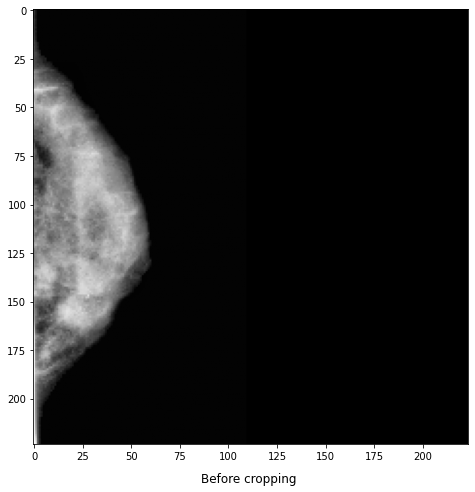

In [44]:
plt.figure(figsize = (50,8))
plt.imshow(res_x.numpy(), cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)

(224, 224, 3)


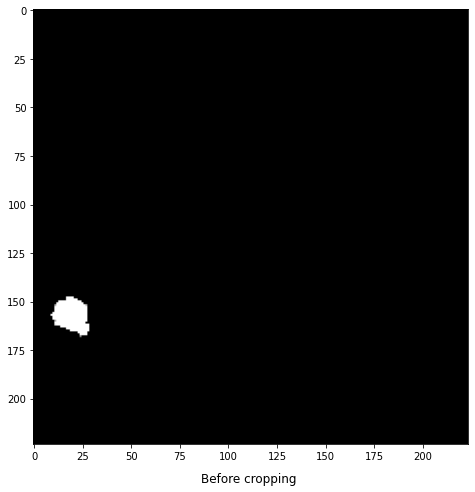

In [45]:
plt.figure(figsize = (50,8))
plt.imshow(res_y.numpy()[:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)

In [46]:
# res_y.numpy()[:,:,0].shape

In [47]:
# res_x.numpy().shape

In [48]:
prediction = unet.predict(test_ds)

In [49]:
# type(prediction)

In [50]:
# prediction.shape

In [51]:
# prediction[0].shape

(224, 224, 3)


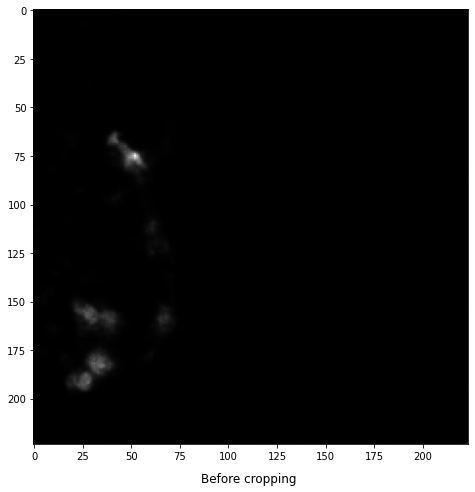

In [52]:
plt.figure(figsize = (50,8))
plt.imshow(prediction[i][:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)